## Lung Cancer Detection using Visual Transformers with LIDC-IDRI

In [1]:
import numpy as np
import pylidc as pl
from PIL import Image
from tensorflow import keras
import matplotlib.pyplot as plt

2022-09-15 01:24:18.392073: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
MAX_TOTAL_ANNOTATIONS = 10

In [3]:
total_images = 0
annotation_list = pl.query(pl.Annotation)
print("Total annotations: ", annotation_list.count())
annotations_count = min(annotation_list.count() , MAX_TOTAL_ANNOTATIONS)
#int(annotation_list.count() * 0.001)
images = []
annotations = []
for i in range(0, annotations_count):
    annotation = annotation_list[i]
    annotation_bbox = annotation.bbox()
    
    vol = annotation.scan.to_volume(verbose=False)

    y0, y1 = annotation_bbox[0].start, annotation_bbox[0].stop
    x0, x1 = annotation_bbox[1].start, annotation_bbox[1].stop

    # Get the central slice of the computed bounding box.
    i, j, k = annotation.centroid
    z = max(int(annotation_bbox[2].stop - k) - 1, 0)
    (w, h) = vol[:, :, int(k)].shape
    
    # bbox = (slice(y0, y1), slice(x0,x1), slice(annotation_bbox[2].start, annotation_bbox[2].stop))
    
    scaled_bbox = (float(x0) / w, float(y0) / h, float(x1) / w, float(y1) / h)

    #

    #print(scaled_bbox)
    
    #plt.imshow(vol[:, :, int(z)], cmap=plt.cm.gray)
    #plt.show()
    
    for j in range(annotation_bbox[2].start, annotation_bbox[2].stop):
        annotations.append(scaled_bbox)
        images.append(vol[:, :, j])
        total_images = total_images + 1

# Convert the list to numpy array, split to train and test dataset
(xtrain), (ytrain) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(annotations[: int(len(annotations) * 0.8)]),
)
(xtest), (ytest) = (
    np.asarray(images[int(len(images) * 0.8):]),
    np.asarray(annotations[int(len(annotations) * 0.8):]),
)

print("Total images used:", total_images)

Total annotations:  6859
Total images used: 58


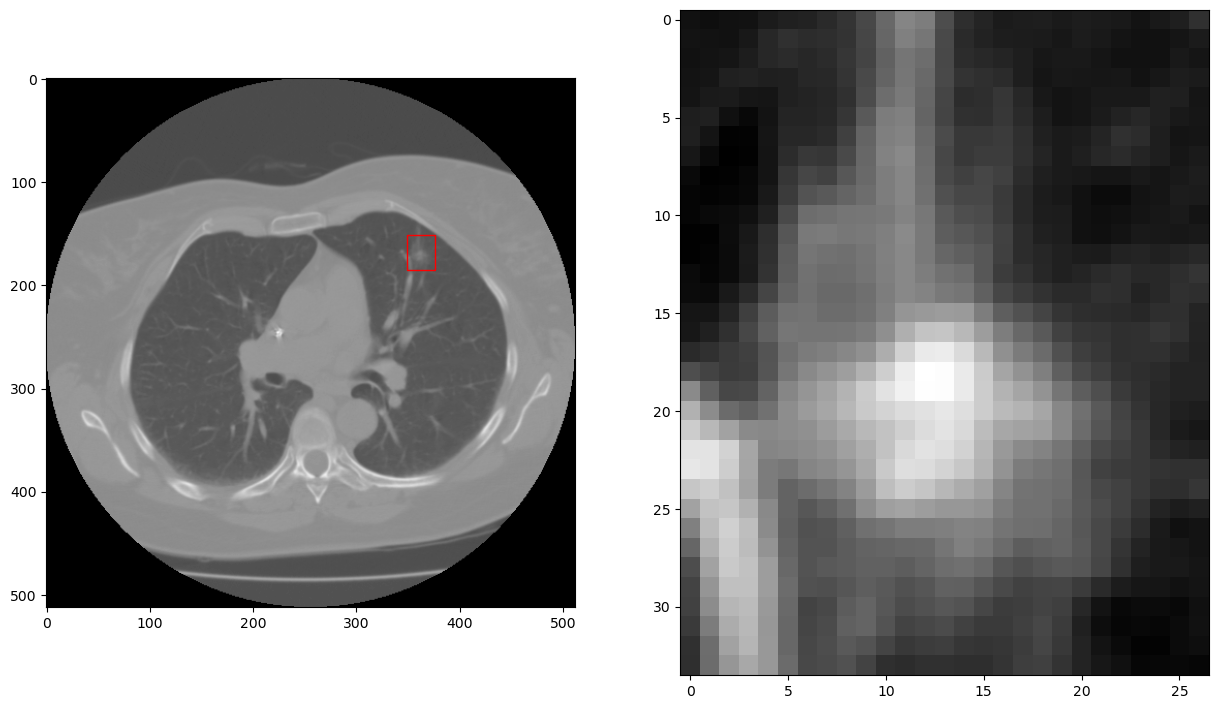

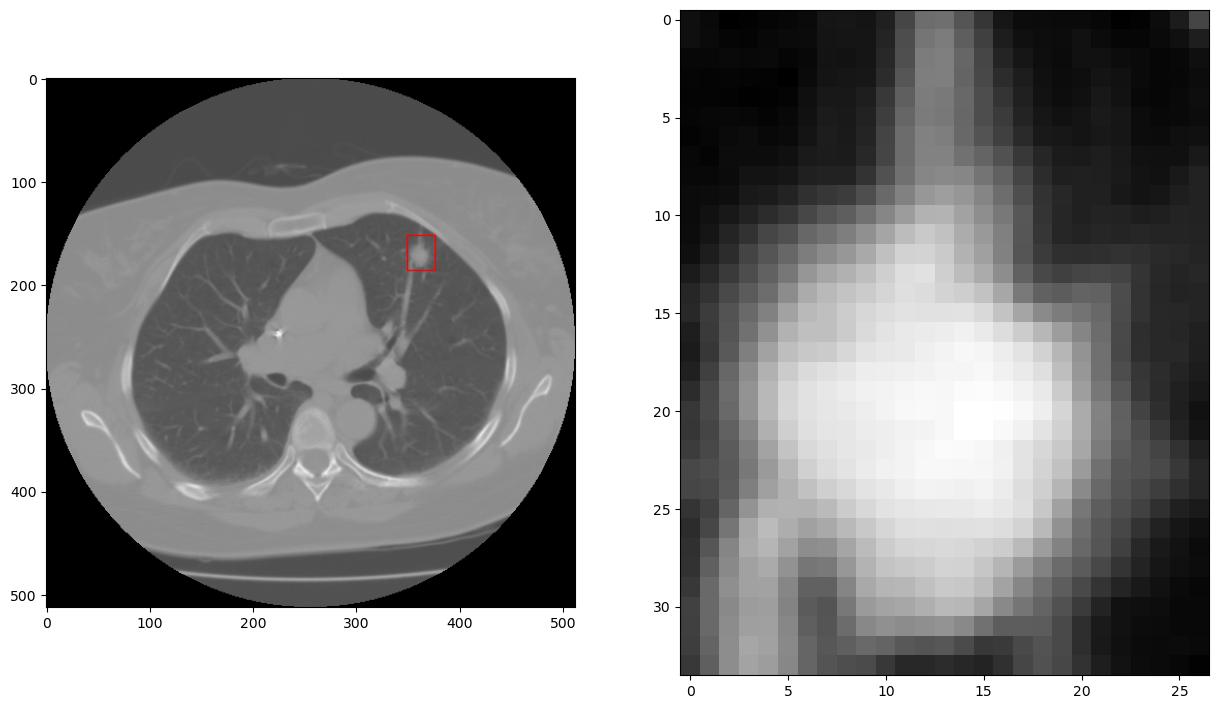

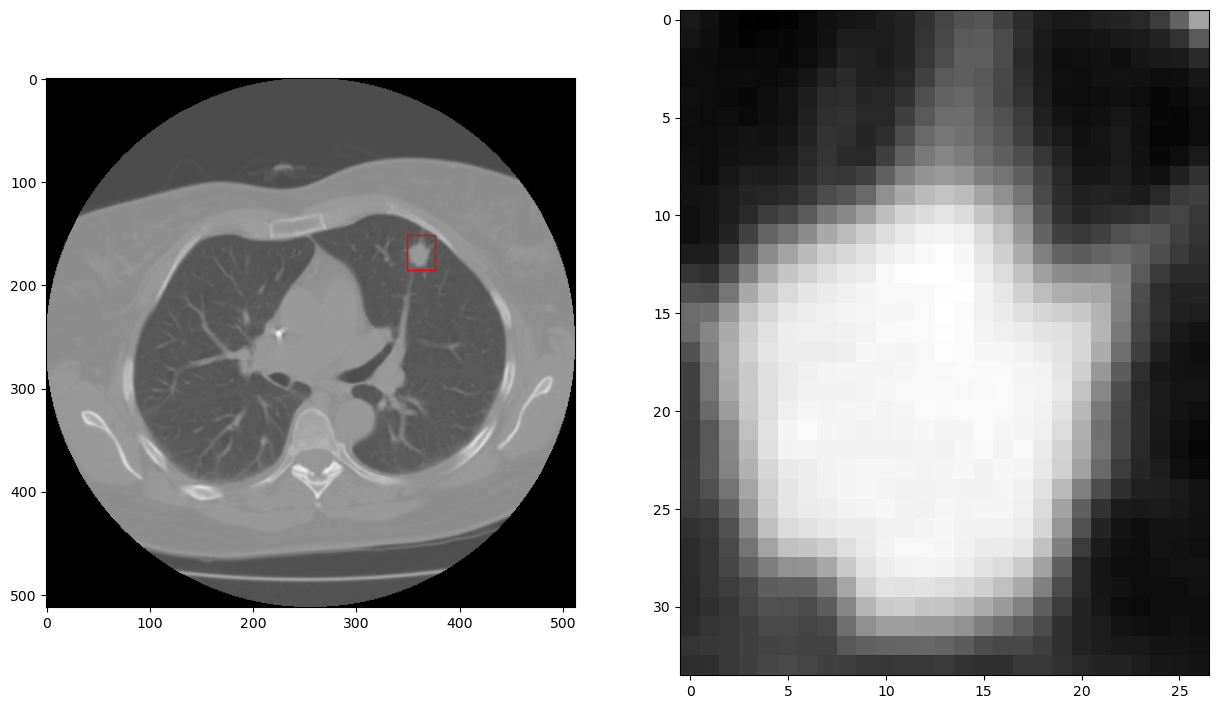

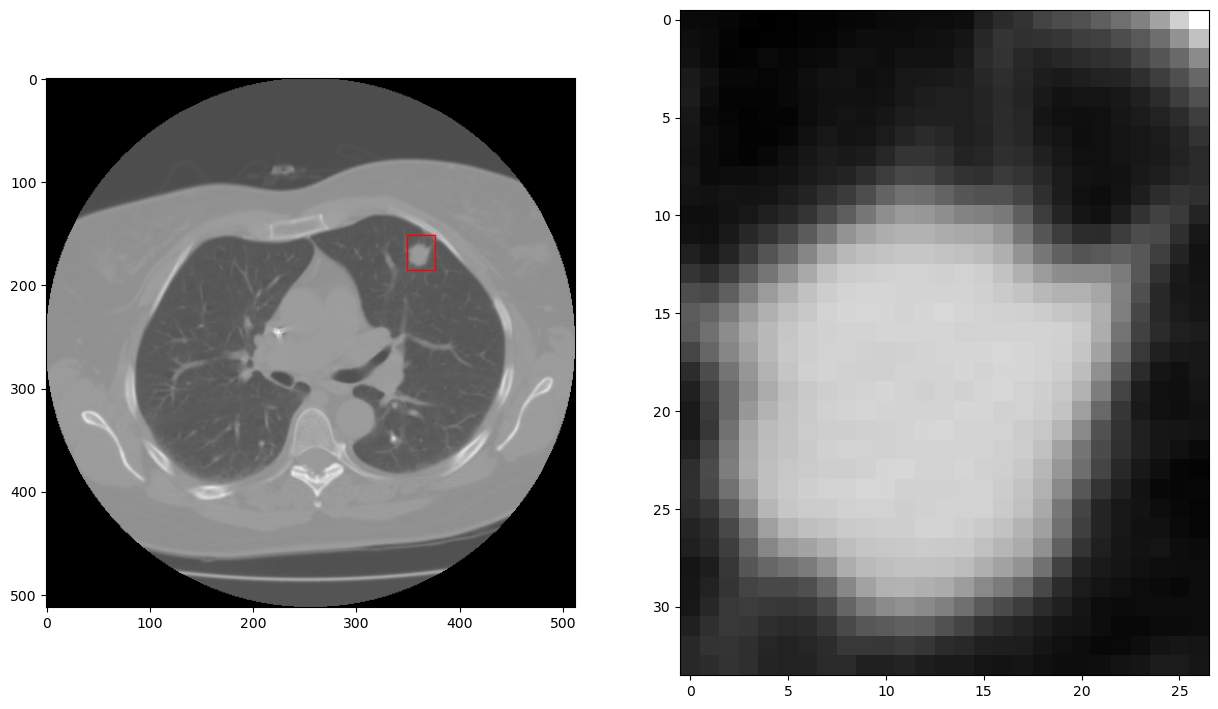

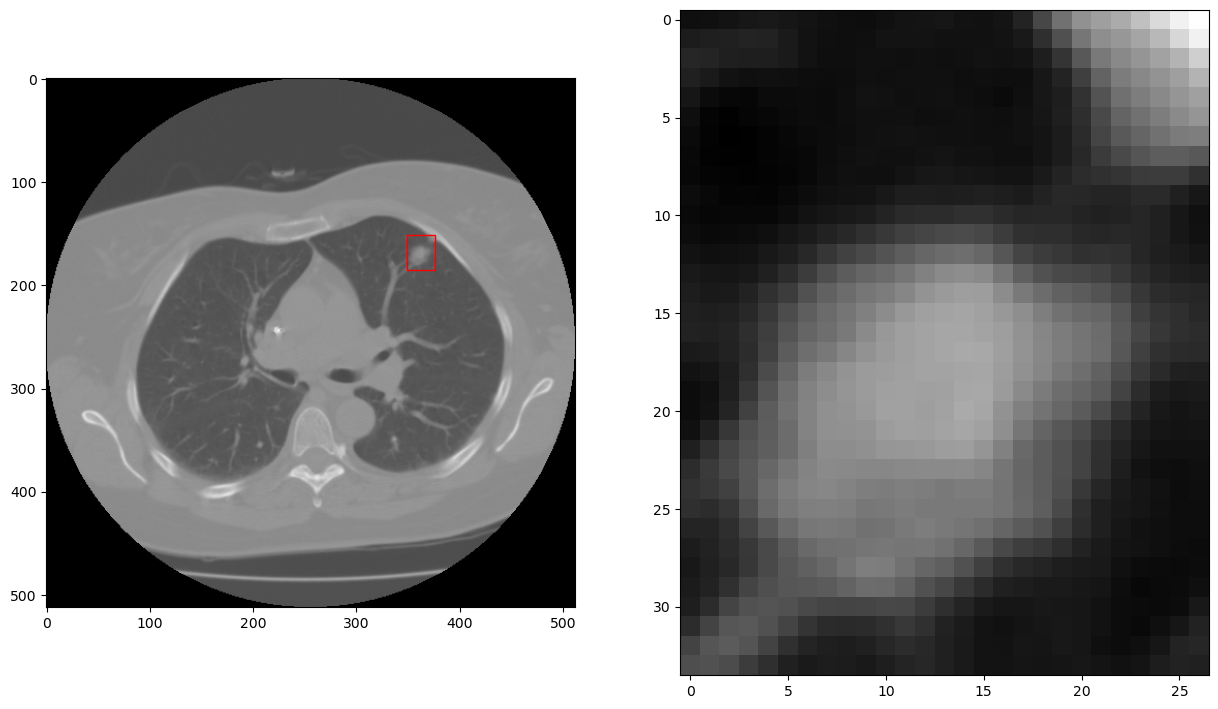

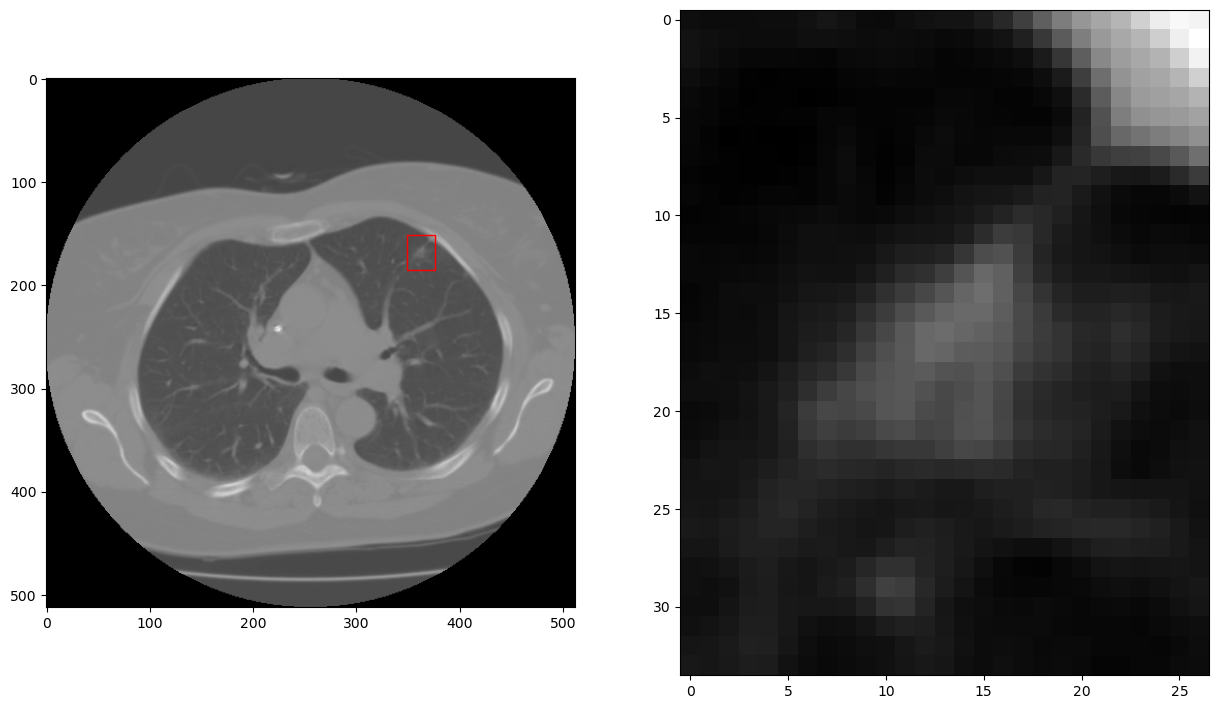

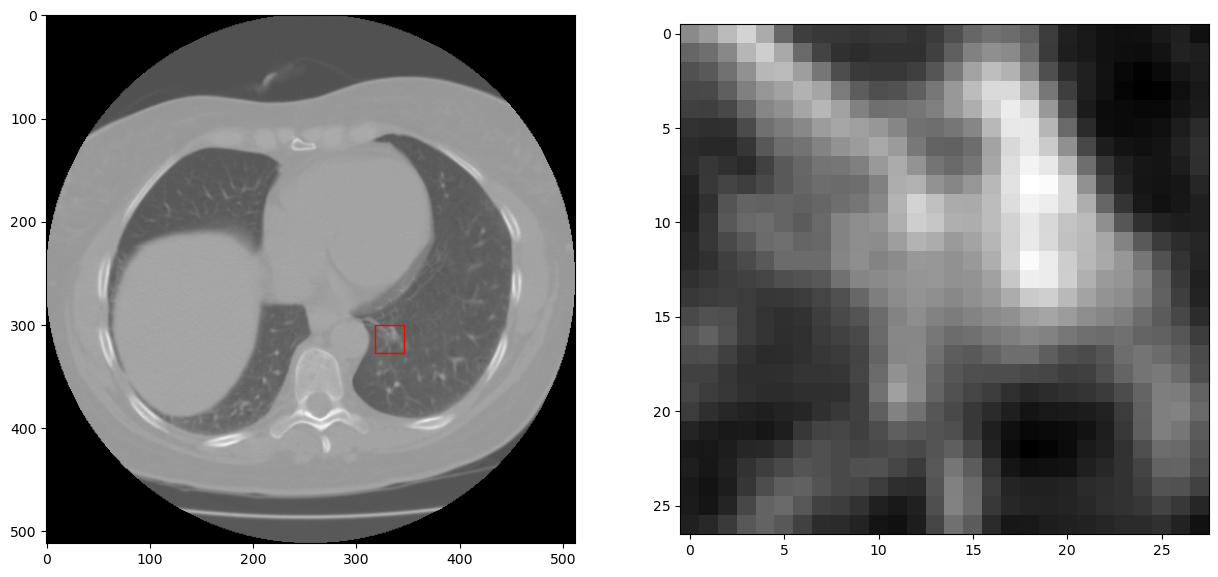

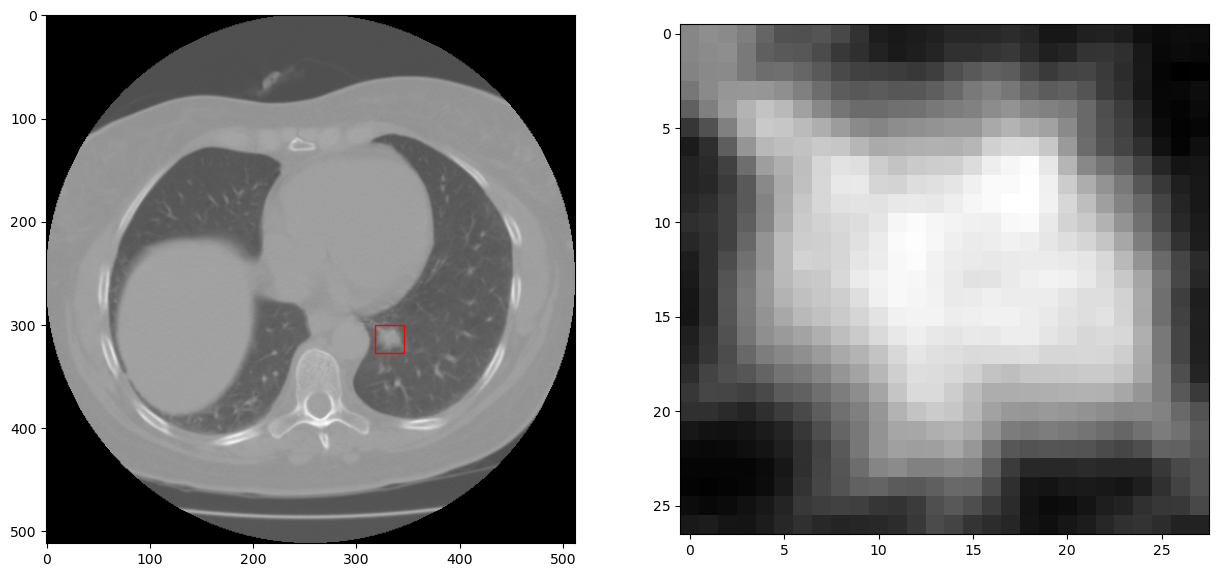

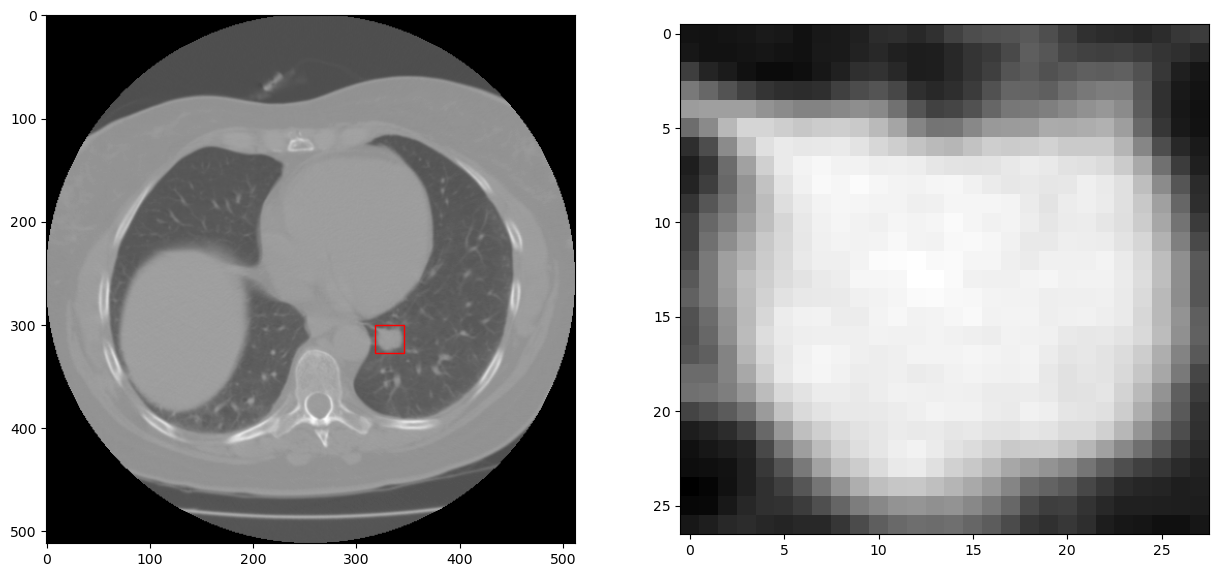

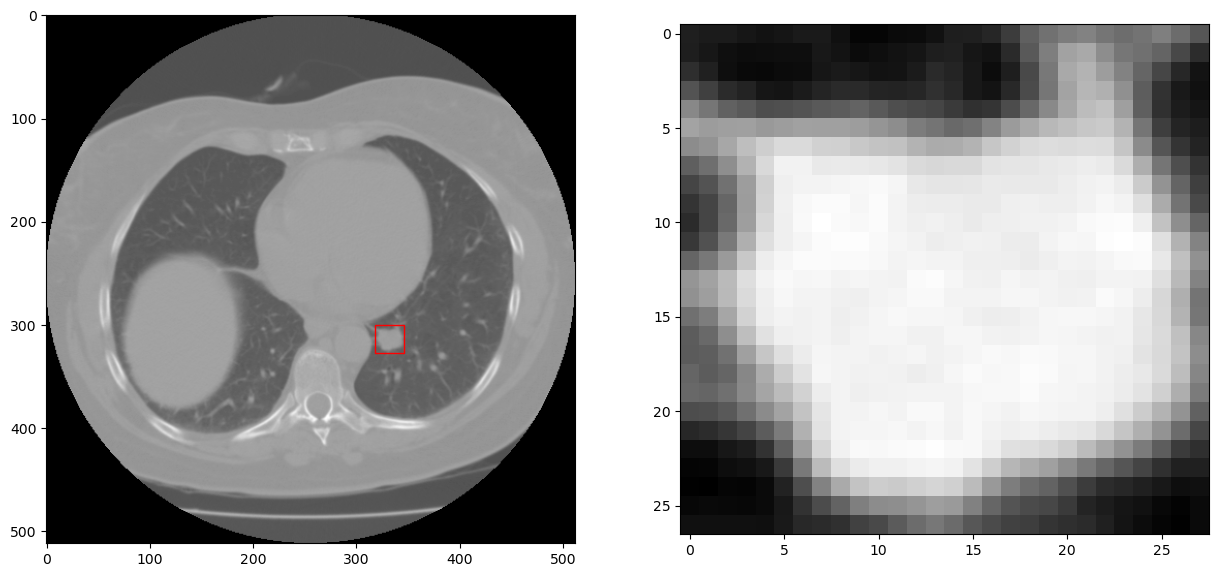

In [4]:
import matplotlib.patches as patches

for i in range(0, min(total_images, 10)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

    (h, w) = (images[i]).shape[0:2]

    y0, y1 = int(annotations[i][1]*h), int(annotations[i][3]*h)
    x0, x1 = int(annotations[i][0]*w), int(annotations[i][2]*w)


    top_left_x, top_left_y = x0, y0
    bottom_right_x, bottom_right_y = x1, y1

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y
    bbox = (slice(top_left_y, bottom_right_y), slice(top_left_x,bottom_right_x))
    ax1.imshow(images[i], cmap=plt.cm.gray)

    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax2.imshow(images[i][(slice(y0, y1), slice(x0, x1))], cmap=plt.cm.gray)
        

In [5]:
import tensorflow as tf
from tensorflow.keras import layers

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size, p_input_shape, p_num_patches, p_projection_dim, p_num_heads, p_transformer_units, p_transformer_layers, p_mlp_head_units):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.p_input_shape = p_input_shape
        self.p_num_patches = p_num_patches
        self.p_projection_dim = p_projection_dim
        self.p_num_heads = p_num_heads
        self.p_transformer_units = p_transformer_units
        self.p_transformer_layers = p_transformer_layers
        self.p_mlp_head_units = p_mlp_head_units

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": self.p_input_shape,
                "patch_size": self.patch_size,
                "num_patches": self.p_num_patches,
                "projection_dim": self.p_projection_dim,
                "num_heads": self.p_num_heads,
                "transformer_units": self.p_transformer_units,
                "transformer_layers": self.p_transformer_layers,
                "mlp_head_units": self.p_mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

"""## Implement the patch encoding layer

The `PatchEncoder` layer linearly transforms a patch by projecting it into a
vector of size `projection_dim`. It also adds a learnable position
embedding to the projected vector.
"""

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, p_patch_size, p_input_shape, p_projection_dim, p_num_heads, p_transformer_units, p_transformer_layers, p_mlp_head_units):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=p_projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=p_projection_dim
        )
        self.p_input_shape = p_input_shape
        self.p_projection_dim = p_projection_dim
        self.p_num_heads = p_num_heads
        self.p_transformer_units = p_transformer_units
        self.p_transformer_layers = p_transformer_layers
        self.p_mlp_head_units = p_mlp_head_units
        self.p_patch_size = p_patch_size

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": self.p_input_shape,
                "patch_size": self.p_patch_size,
                "num_patches": self.num_patches,
                "projection_dim": self.p_projection_dim,
                "num_heads": self.p_num_heads,
                "transformer_units": self.p_transformer_units,
                "transformer_layers": self.p_transformer_layers,
                "mlp_head_units": self.p_mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size, input_shape, num_patches, projection_dim, num_heads,
                  transformer_units, transformer_layers, mlp_head_units)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, patch_size, input_shape, projection_dim, num_heads,
                  transformer_units, transformer_layers, mlp_head_units)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_addons as tfa
from tensorflow import keras

In [10]:
def print_results(vit_object_detector, image_size, x_test, y_test):
    import matplotlib.patches as patches

    # Saves the model in current path
    vit_object_detector.save("vit_object_detector.h5", save_format="h5")

    i, mean_iou = 0, 0

    # Compare results for 10 images in the test set
    for input_image in x_test[:10]:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
        im = input_image

        # Display the image
        ax1.imshow(im, cmap=plt.cm.gray)
        ax2.imshow(im, cmap=plt.cm.gray)

        #input_image = cv2.resize(
        #    input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
        #)
        input_image = np.expand_dims(input_image, axis=0)
        preds = vit_object_detector.predict(input_image)[0]

        (h, w) = (im).shape[0:2]

        top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

        bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

        box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
        # Create the bounding box
        rect = patches.Rectangle(
            (top_left_x, top_left_y),
            bottom_right_x - top_left_x,
            bottom_right_y - top_left_y,
            facecolor="none",
            edgecolor="red",
            linewidth=1,
        )
        # Add the bounding box to the image
        ax1.add_patch(rect)
        ax1.set_xlabel(
            "Predicted: "
            + str(top_left_x)
            + ", "
            + str(top_left_y)
            + ", "
            + str(bottom_right_x)
            + ", "
            + str(bottom_right_y)
        )

        top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

        bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

        box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

        mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
        # Create the bounding box
        rect = patches.Rectangle(
            (top_left_x, top_left_y),
            bottom_right_x - top_left_x,
            bottom_right_y - top_left_y,
            facecolor="none",
            edgecolor="red",
            linewidth=1,
        )
        # Add the bounding box to the image
        ax2.add_patch(rect)
        ax2.set_xlabel(
            "Target: "
            + str(top_left_x)
            + ", "
            + str(top_left_y)
            + ", "
            + str(bottom_right_x)
            + ", "
            + str(bottom_right_y)
            + "\n"
            + "IoU"
            + str(bounding_box_intersection_over_union(box_predicted, box_truth))
        )
        i = i + 1

    print("mean_iou: " + str(mean_iou / len(x_test[:10])))
    plt.show()



In [11]:
TRAIN_SIZE = 0.8
TEST_SIZE = 1 - TRAIN_SIZE
IMAGE_SIZE = 512
patch_size = 128  # Size of the patches to be extracted from the input images
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)  # input image shape
learning_rate = 0.002
weight_decay = 0.00001
batch_size = 64
num_epochs = 150
num_patches = (IMAGE_SIZE // patch_size) ** 2
projection_dim = 64
num_heads = 12
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 12
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers
history = []
num_patches = (IMAGE_SIZE // patch_size) ** 2

In [12]:
vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-09-15 01:24:25.177298: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-15 01:24:25.178718: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-15 01:24:25.214339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 01:24:25.214468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 Laptop GPU computeCapability: 8.6
coreClock: 1.245GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2022-09-15 01:24:25.214485: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-15 01:24:25.215347: I tensorflow/stream_executor/

In [13]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs, x_train, y_train):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "../logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback
        ],
    )

    return history

In [14]:
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs, xtrain, ytrain
)



2022-09-15 01:24:26.567583: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-15 01:24:26.589648: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3293845000 Hz


Epoch 1/150


2022-09-15 01:24:29.162012: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


1/1 [==============================] - 3s 3s/step - loss: 2.6337 - val_loss: 0.5815
Epoch 2/150
1/1 [==============================] - 0s 159ms/step - loss: 83.0184 - val_loss: 1.4813
Epoch 3/150
1/1 [==============================] - 0s 149ms/step - loss: 39.0980 - val_loss: 5.7018
Epoch 4/150
1/1 [==============================] - 0s 133ms/step - loss: 33.6499 - val_loss: 30.3590
Epoch 5/150
1/1 [==============================] - 0s 135ms/step - loss: 85.4043 - val_loss: 7.2141
Epoch 6/150
1/1 [==============================] - 0s 147ms/step - loss: 36.7009 - val_loss: 0.2702
Epoch 7/150
1/1 [==============================] - 0s 142ms/step - loss: 29.5506 - val_loss: 0.2402
Epoch 8/150
1/1 [==============================] - 0s 154ms/step - loss: 16.4642 - val_loss: 0.3497
Epoch 9/150
1/1 [==============================] - 0s 160ms/step - loss: 9.6699 - val_loss: 0.3503
Epoch 10/150
1/1 [==============================] - 0s 152ms/step - loss: 4.9781 - val_loss: 0.3507
Epoch 11/150
1/1

1/1 [==============================] - 0s 135ms/step - loss: 0.2272 - val_loss: 0.2189
Epoch 84/150
1/1 [==============================] - 0s 137ms/step - loss: 0.2236 - val_loss: 0.2169
Epoch 85/150
1/1 [==============================] - 0s 134ms/step - loss: 0.2214 - val_loss: 0.2149
Epoch 86/150
1/1 [==============================] - 0s 139ms/step - loss: 0.2187 - val_loss: 0.2128
Epoch 87/150
1/1 [==============================] - 0s 139ms/step - loss: 0.2192 - val_loss: 0.2108
Epoch 88/150
1/1 [==============================] - 0s 138ms/step - loss: 0.2134 - val_loss: 0.2088
Epoch 89/150
1/1 [==============================] - 0s 134ms/step - loss: 0.2138 - val_loss: 0.2068
Epoch 90/150
1/1 [==============================] - 0s 140ms/step - loss: 0.2084 - val_loss: 0.2048
Epoch 91/150
1/1 [==============================] - 0s 133ms/step - loss: 0.2085 - val_loss: 0.2028
Epoch 92/150
1/1 [==============================] - 0s 133ms/step - loss: 0.2098 - val_loss: 0.2009
Epoch 93/150


mean_iou: 0.0


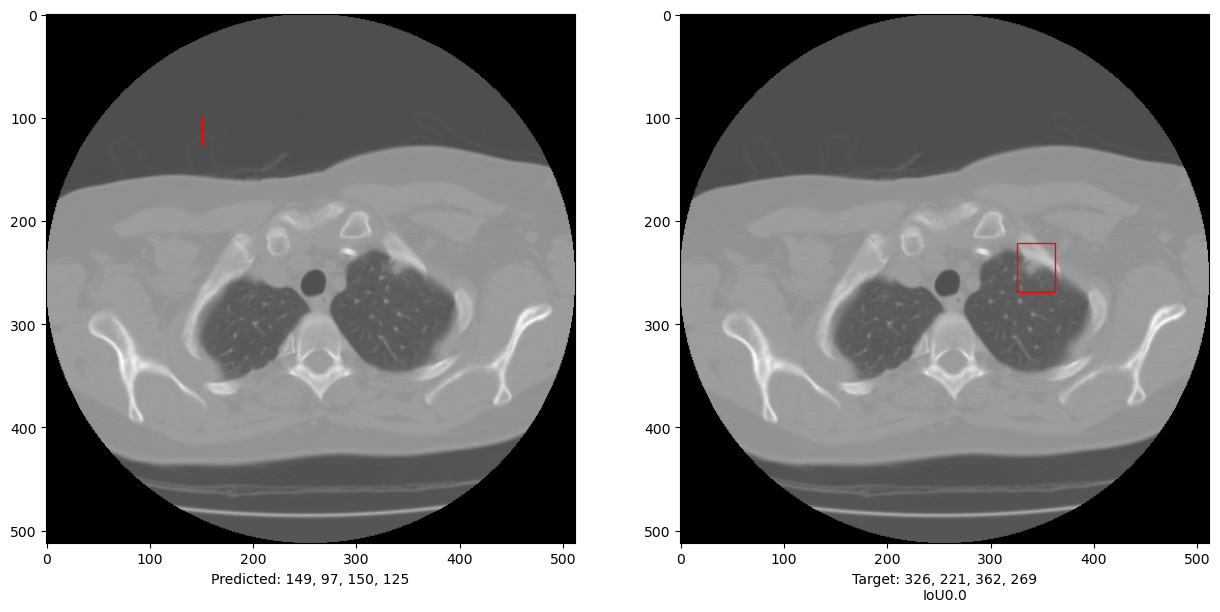

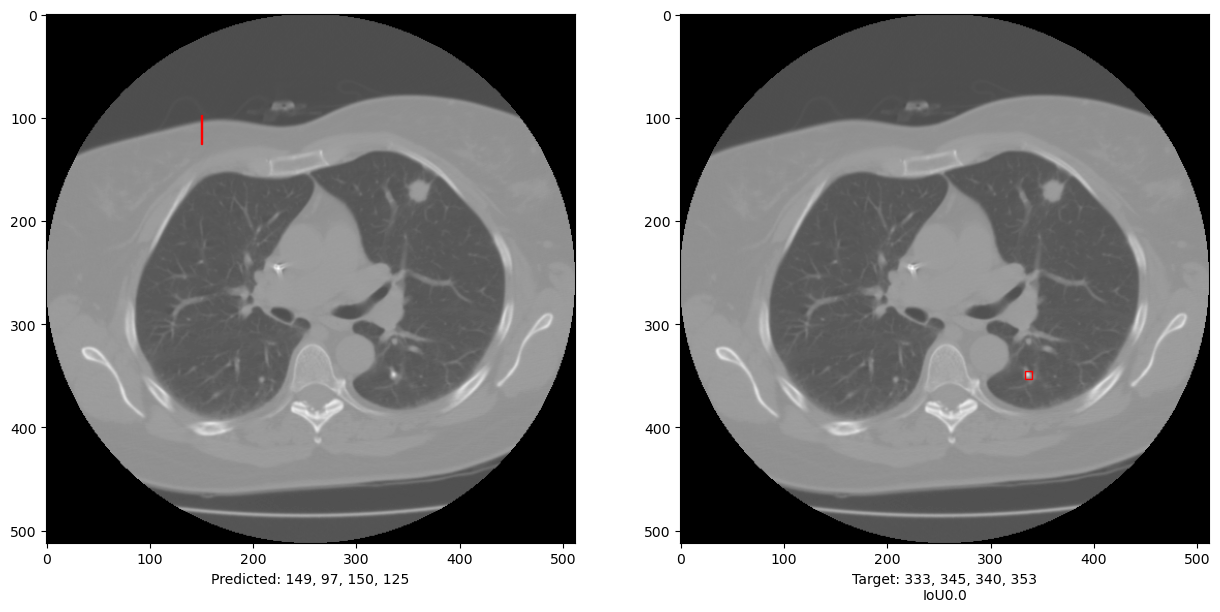

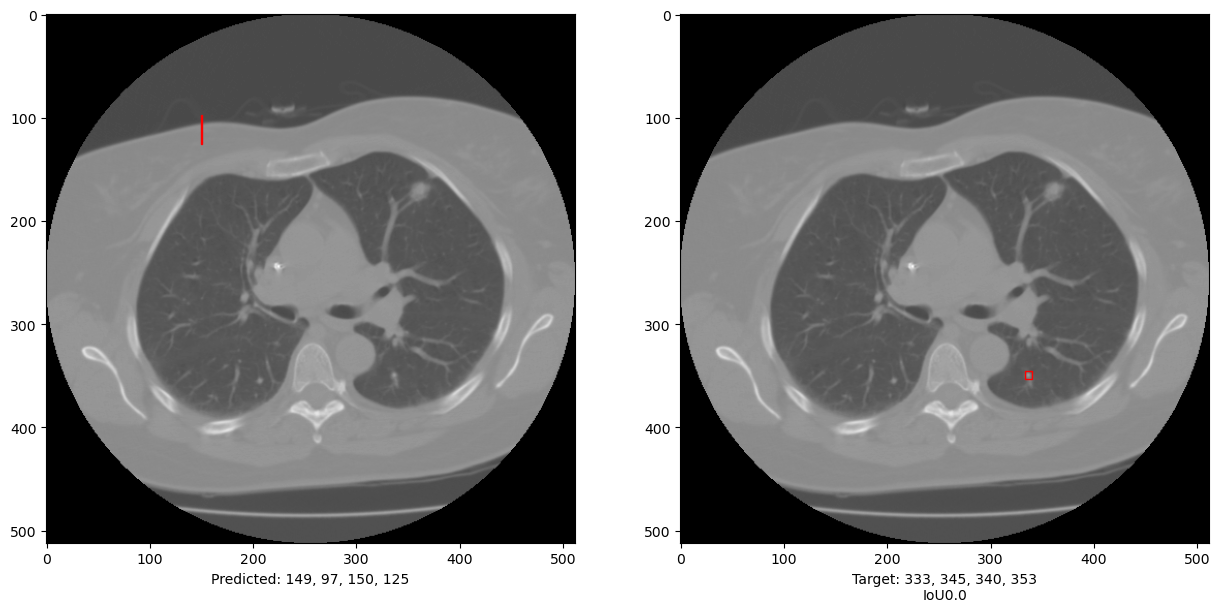

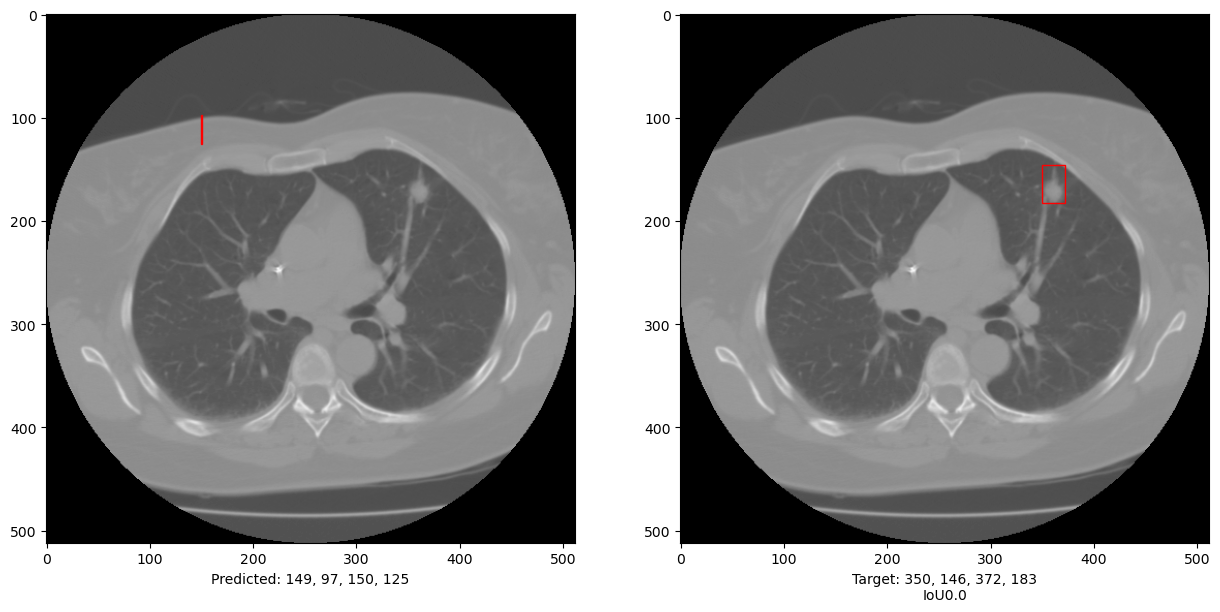

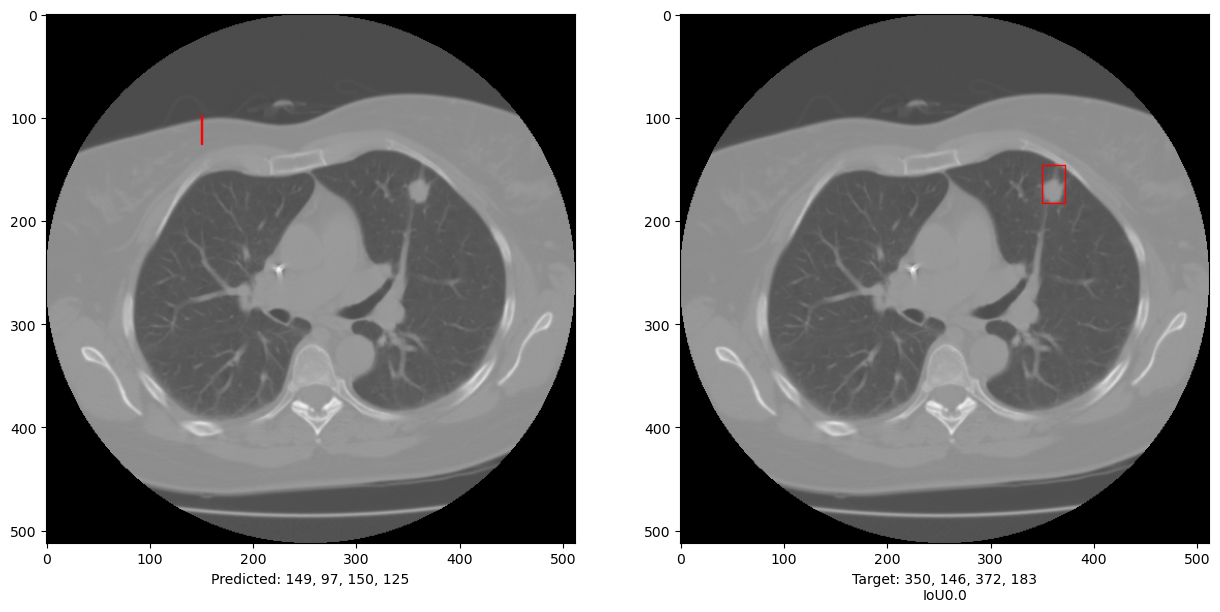

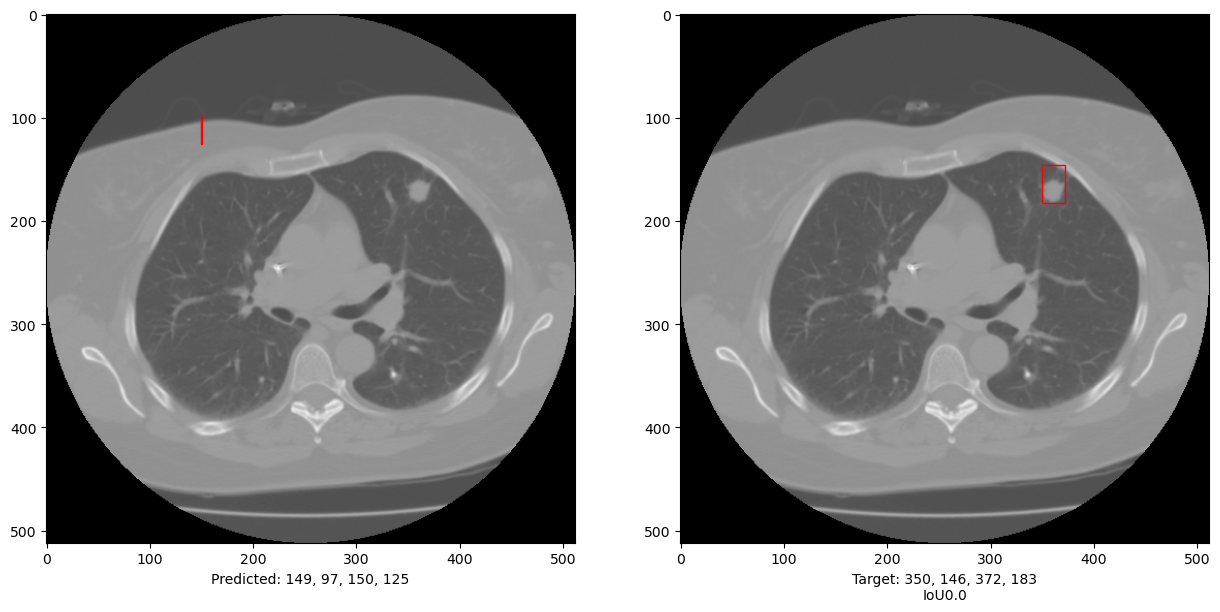

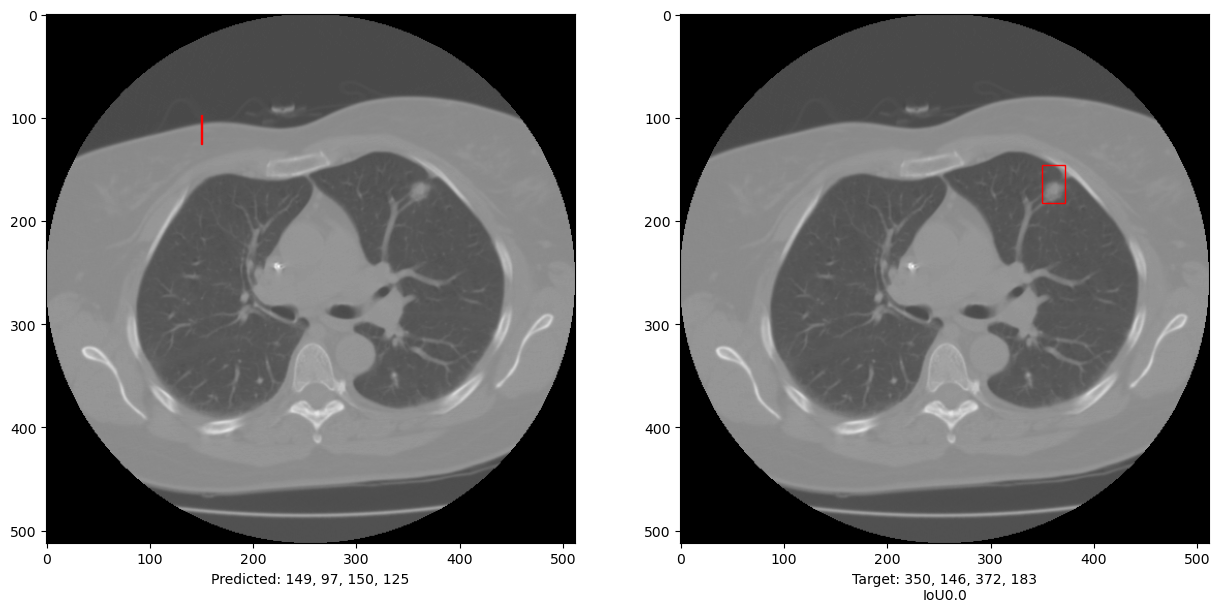

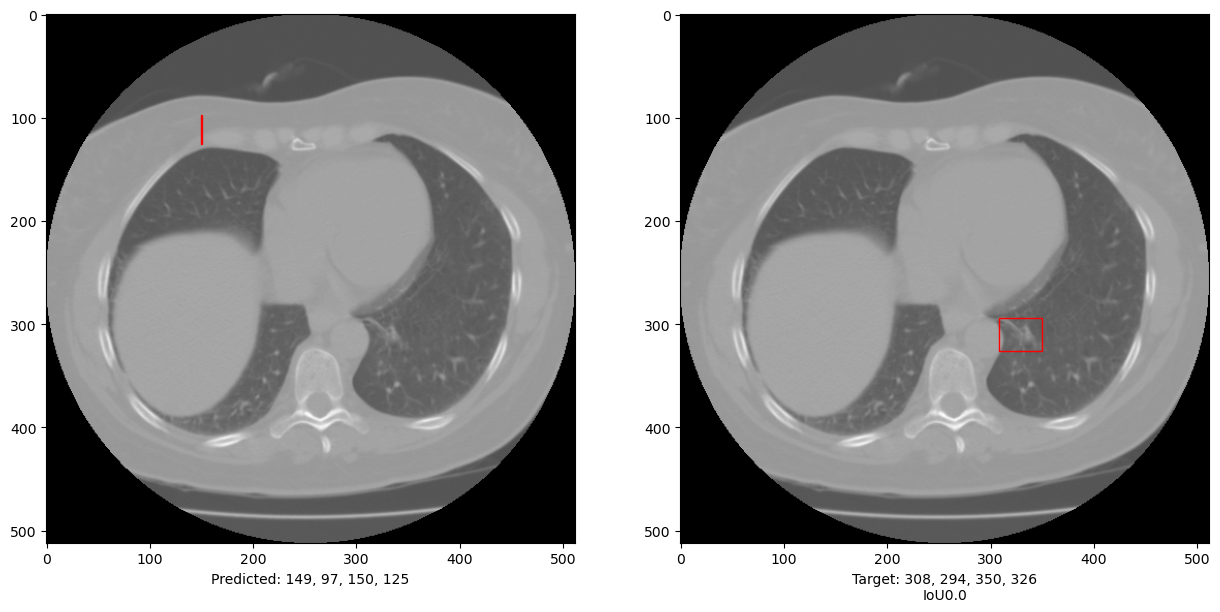

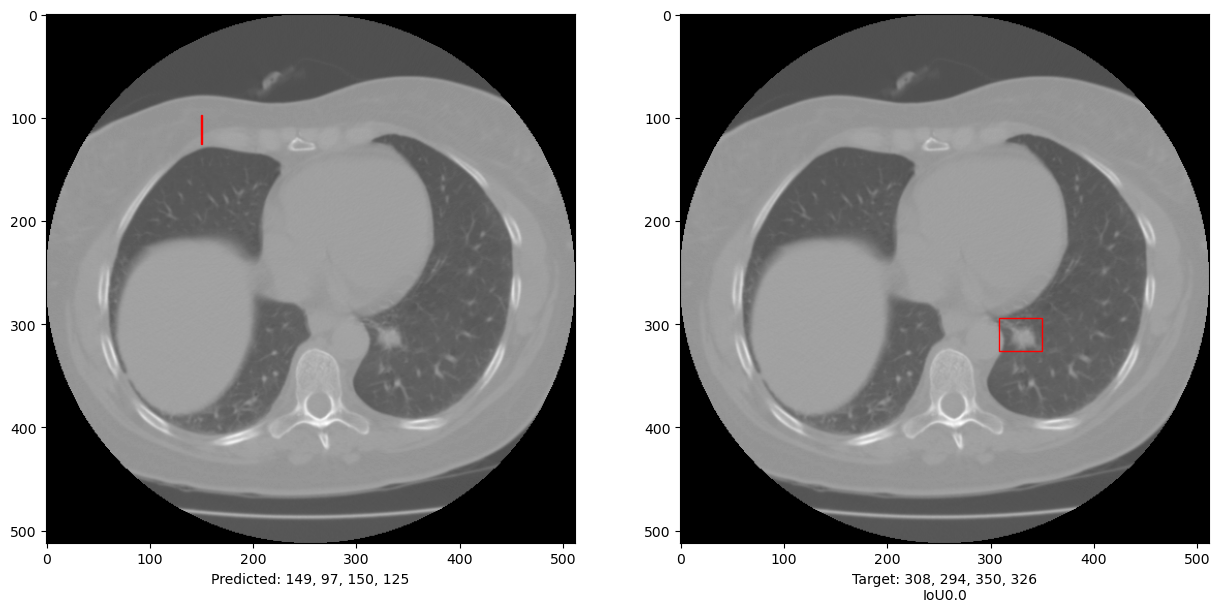

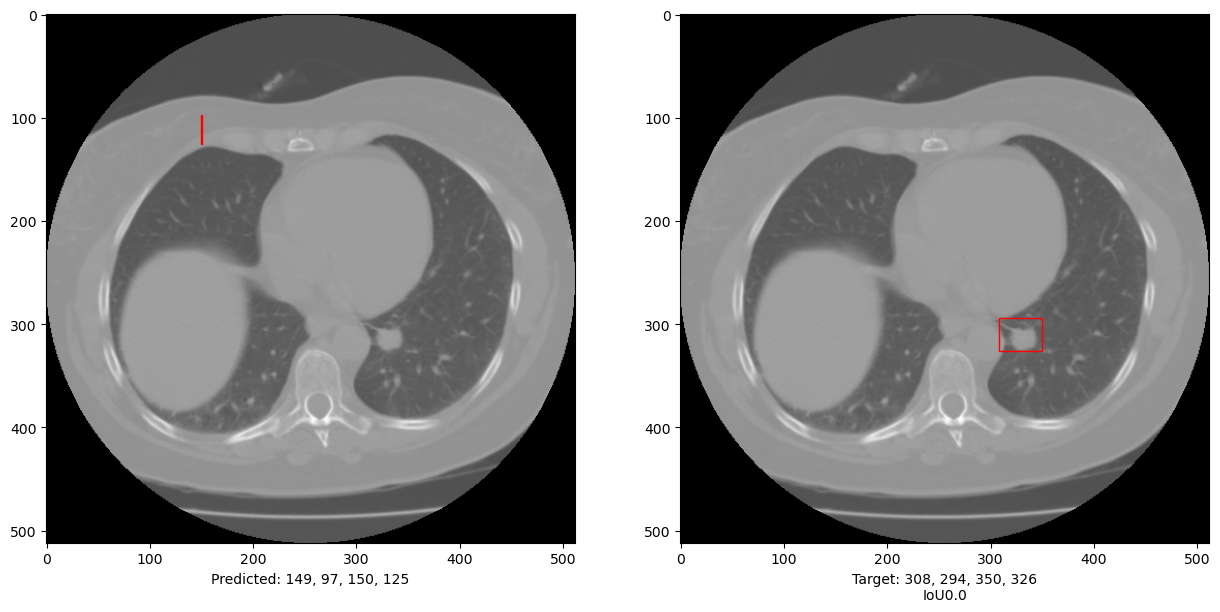

In [15]:
# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )

print_results(vit_object_detector, IMAGE_SIZE, xtest, ytest)